In [2]:
# Imports iniciales

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.preprocessing import KBinsDiscretizer
from data_gen import *
from copy import deepcopy
from matplotlib import pyplot as mpl
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer


## Ejercicio 1

In [5]:
def bayes_train(X_train, y_train, X_test, y_test):
    clf = GaussianNB()

    clf.fit(X_train, np.ravel(y_train))

    results_train = clf.predict(X_train)
    results_test = clf.predict(X_test)

    error_train = 1-accuracy_score(results_train, y_train)
    error_test = 1-accuracy_score(results_test, y_test)

    return error_train, error_test

def ejercicio_1():
    c = 0.78
    n = 250

    d_values = [2, 4, 8, 16, 32]

    errors = []

    for d in d_values:
        centros_a = centros_eja(d)

        test_case_a = generar_valores(centros_a, c * sqrt(d), d, 10000)
        X_test, y_test = test_case_a.iloc[:, :-1], test_case_a.iloc[:, -1:]

        test_error_para = 0.0
        values_error_para = 0.0
        test_error_diag = 0.0
        values_error_diag = 0.0

        for j in range(20):
            values = generar_valores(centros_a, c * sqrt(d), d, n)
            X_train, y_train = values.iloc[:, :-1], values.iloc[:, -1:]

            v_errors, t_errors = bayes_train(X_train, y_train, X_test, y_test)

            test_error_para += t_errors
            values_error_para += v_errors

        test_error_para = test_error_para / 20
        values_error_para = values_error_para / 20

        centros_b = centros_ejb(d)
        test_case_b = generar_valores(centros_b, c, d, 10000)
        X_test, y_test = test_case_b.iloc[:, :-1], test_case_b.iloc[:, -1:]

        for j in range(20):
            values = generar_valores(centros_b, c, d, n)
            X_train, y_train = values.iloc[:, :-1], values.iloc[:, -1:]

            v_errors, t_errors = bayes_train(X_train, y_train, X_test, y_test)

            test_error_diag += t_errors
            values_error_diag += v_errors

        test_error_diag = test_error_diag / 20
        values_error_diag = values_error_diag / 20

        errors.append([test_error_para, d, "Test_Parallel_BY"])
        errors.append([values_error_para, d, "Val_Parallel_BY"])
        errors.append([test_error_diag, d, "Test_Diagonal_BY"])
        errors.append([values_error_diag, d, "Val_Diagonal_BY"])

    df_errors = pd.DataFrame(errors, columns=["Error", "D", "Type"])
    df_errors.to_csv("TP_3/errors_ej_1.csv", index=False)

In [10]:
def ejercicio_1_print():
    df_errors_tree = pd.read_csv("TP_1/errors_ej_4.csv")
    df_errors_nn = pd.read_csv("TP_2/errors_ej_5.csv")
    df_errors_bayes = pd.read_csv("TP_3/errors_ej_1.csv")
    df_errors = pd.concat([df_errors_tree, df_errors_nn, df_errors_bayes])
    plot_error_lines_with_dimensions(df_errors)


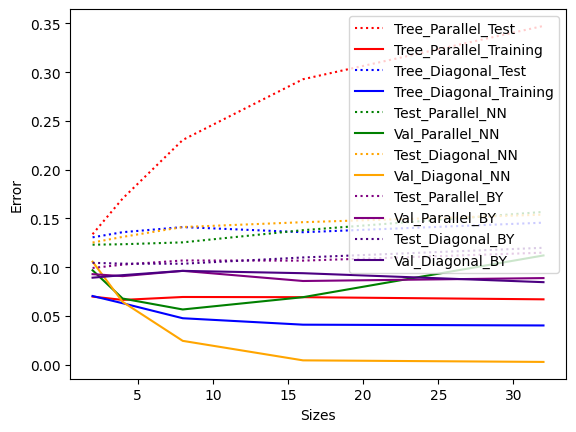

In [11]:
ejercicio_1_print()

### Conclusiones ejercicio 1

Como podemos observar, de todos los casos hasta ahora Bayes es el mejor. El error tiende a 0.1 que es el esperado, y el error de Test para ambos casos es el menor de todos por una diferencia lo suficientemente significativa.

## Ejercicio 2

In [12]:
def ejercicio_2_elipses():
    columns = ["0","1","Class"]

    data = pd.read_csv(
        "TP_2/dos_elipses.data",
        names=columns,
        header=None,
    )

    test = pd.read_csv(
        "TP_2/dos_elipses.test",
        names=columns,
        header=None,
    )

    X_train, y_train = data.iloc[:, :-1], data.iloc[:, -1:]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1:]

    clf = GaussianNB()
    clf.fit(X_train, np.ravel(y_train))

    results_test = clf.predict(X_test)

    df_results_bayes = X_test
    df_results_bayes["Class"] = results_test

    df_results_nn = pd.read_csv("TP_3/nn_results_elipses_2.csv")

    plot(test, "Original results")
    plot(df_results_nn, "NN results")
    plot(df_results_bayes, "Bayes results")

def ejercicio_2_espirales():

    test = generar_espirales(2000)
    data = generar_espirales(600)

    X_train, y_train = data.iloc[:, :-1], data.iloc[:, -1:]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1:]


    clf = GaussianNB()
    clf.fit(X_train, np.ravel(y_train))

    results_test = clf.predict(X_test)

    df_results_bayes = X_test
    df_results_bayes["Class"] = results_test

    df_results_nn = pd.read_csv("TP_3/nn_results_espirales_2.csv")

    plot(test, "Original results")
    plot(df_results_nn, "NN results")
    plot(df_results_bayes, "Bayes results")


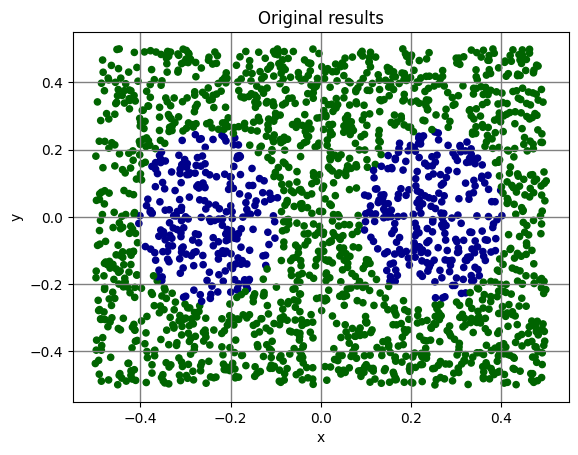

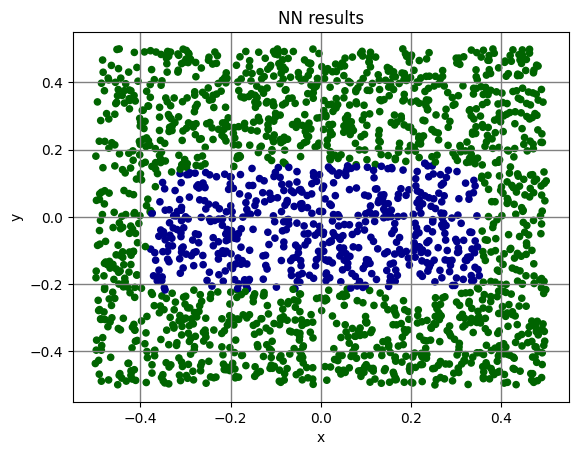

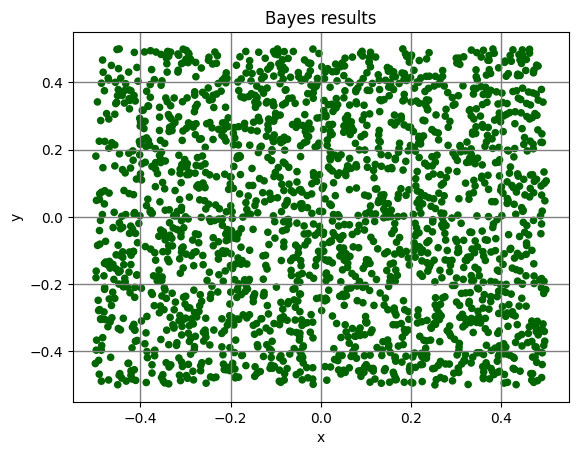

In [13]:
ejercicio_2_elipses()

### Conclusiones ejercicio 2 Elipses

En particular para las elipses podemos notar que Naive Bayes no funciona. Una gaussiana no sirve para representar este problema en particular, ya que claramente asume que todos son de la misma clase

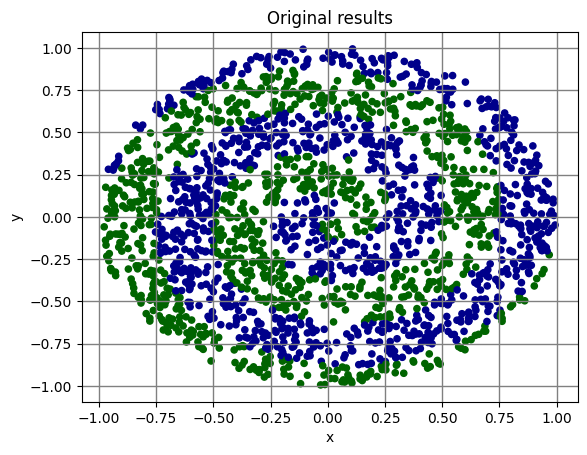

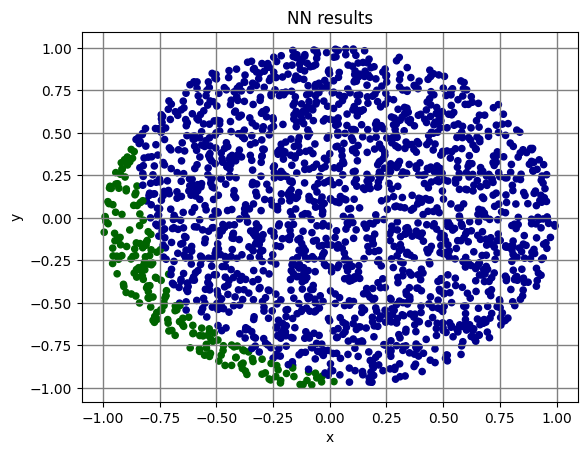

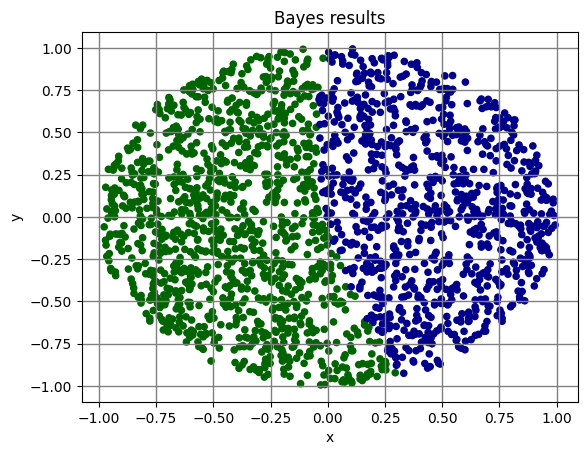

In [14]:
ejercicio_2_espirales()

### Conclusiones Ejercicio 2 Espirales

Similar a las elipses, para las espirales podemos notar que Naive Bayes tampoco funciona. Con un par de gaussianas podemos ver que hay picos pequeños en base a la forma de las espirales, pero no se asemeja para nada a la espiral original.

## Ejercicio 3

In [3]:
def entrenar_CategoricalNB(list_bins, X_train, y_train, X_val, y_val, X_test, y_test ):  
    errors = []
    best_val_error = 1

    for bins in list_bins:
        kbdisc = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
        kbdisc.fit(X_train)

        X_train_discrete = kbdisc.transform(X_train.copy())
        X_val_discrete = kbdisc.transform(X_val.copy())
        X_test_discrete = kbdisc.transform(X_test.copy())

        bnet = CategoricalNB(min_categories=bins)
        bnet.fit(X_train_discrete, np.ravel(y_train))

        results_train = bnet.predict(X_train_discrete)
        results_val = bnet.predict(X_val_discrete)
        results_test= bnet.predict(X_test_discrete)

        train_error = 1 - accuracy_score(y_train, results_train)
        val_error = 1 - accuracy_score(y_val, results_val)
        test_error = 1 - accuracy_score(y_test, results_test)

        errors.append([train_error, bins, "Train error"])
        errors.append([val_error, bins, "Validation error"])
        errors.append([test_error, bins, "Test error"])

        if val_error < best_val_error:
            best_val_error = val_error
            best_bins = bins
            best_bnet = deepcopy(bnet)
            best_kbdisc = deepcopy(kbdisc)

    df_errors = pd.DataFrame(errors, columns = ["Error", "Bins", "Clase"])

    return best_bins, df_errors, best_bnet, best_kbdisc

## Ejercicio 4

In [4]:
def ejercicio_4_elipses():
    columns = ["0","1","Class"]

    data = pd.read_csv(
        "TP_2/dos_elipses.data",
        names=columns,
        header=None,
    )

    test = pd.read_csv(
        "TP_2/dos_elipses.test",
        names=columns,
        header=None,
    )
    
    X_raw, y_raw = data.iloc[:, :-1], data.iloc[:, -1:]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1:]

    X_train, X_val, y_train, y_val = train_test_split(
        X_raw, y_raw, test_size=0.2, random_state=42
    )

    # Classic Bayes
    
    clf = GaussianNB()
    clf.fit(X_train, np.ravel(y_train))

    results_test = clf.predict(X_test)

    df_results_bayes = X_test.copy()
    df_results_bayes["Class"] = results_test

    ## Bins discrete Bayes

    list_bins = range(2,100,2)

    best_bins, df_errors, best_bnet, best_kbdisc = entrenar_CategoricalNB(list_bins, X_train, y_train, X_val, y_val, X_test, y_test )

    X_test_discrete = best_kbdisc.transform(X_test.copy())
    results_bins_test = best_bnet.predict(X_test_discrete)

    df_results_bins_bayes = X_test
    df_results_bins_bayes["Class"] = results_bins_test

    print("Best result was "+ str(best_bins))
    plot(test, "Original results")
    plot(df_results_bayes, "Bayes results")
    plot(df_results_bins_bayes, "Bayes bins results")

    plot_error_bins(df_errors, title="Errors with bins")


def ejercicio_4_espirales():

    test = generar_espirales(2000)
    data = generar_espirales(600)

    X_raw, y_raw = data.iloc[:, :-1], data.iloc[:, -1:]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1:]

    X_train, X_val, y_train, y_val = train_test_split(
        X_raw, y_raw, test_size=0.2, random_state=42
    )

    # Classic Bayes
    
    clf = GaussianNB()
    clf.fit(X_train, np.ravel(y_train))

    results_test = clf.predict(X_test)

    df_results_bayes = X_test.copy()
    df_results_bayes["Class"] = results_test

    ## Bins discrete Bayes

    list_bins = range(2,100,2)

    best_bins, df_errors, best_bnet, best_kbdisc = entrenar_CategoricalNB(list_bins, X_train, y_train, X_val, y_val, X_test, y_test )

    X_test_discrete = best_kbdisc.transform(X_test.copy())
    results_bins_test = best_bnet.predict(X_test_discrete)

    df_results_bins_bayes = X_test
    df_results_bins_bayes["Class"] = results_bins_test

    print("Best result was "+ str(best_bins))
    plot(test, "Original results")
    plot(df_results_bayes, "Bayes results")
    plot(df_results_bins_bayes, "Bayes bins results")

    plot_error_bins(df_errors, title="Errors with bins")


Best result was 42


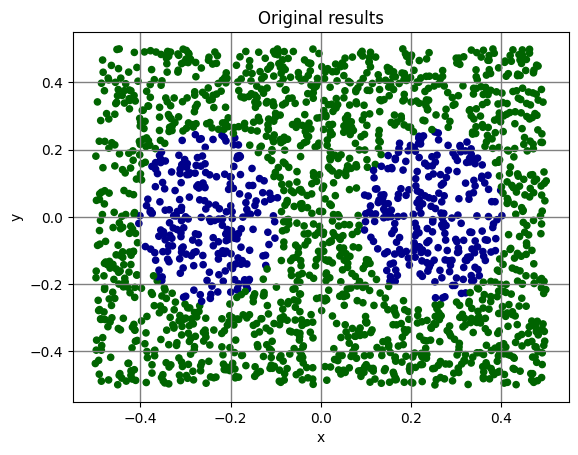

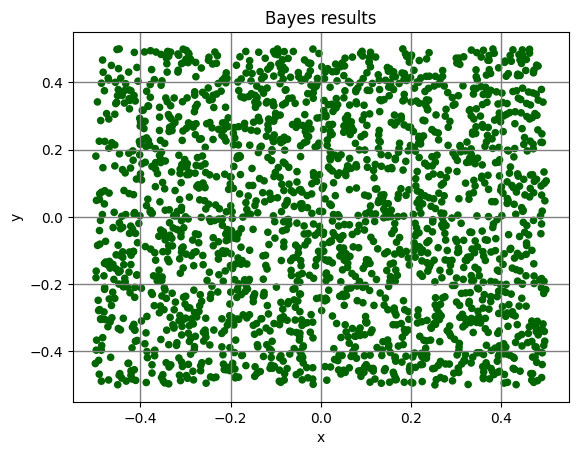

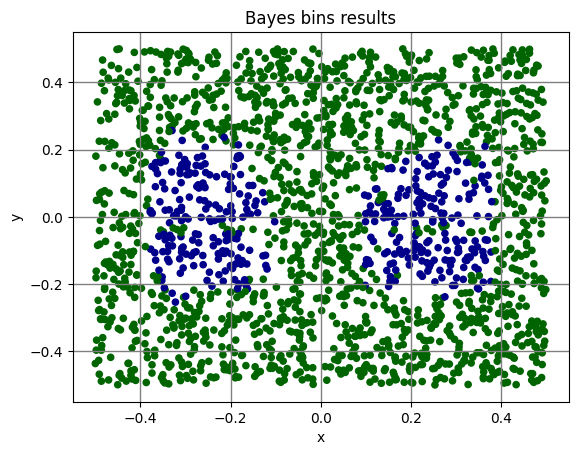

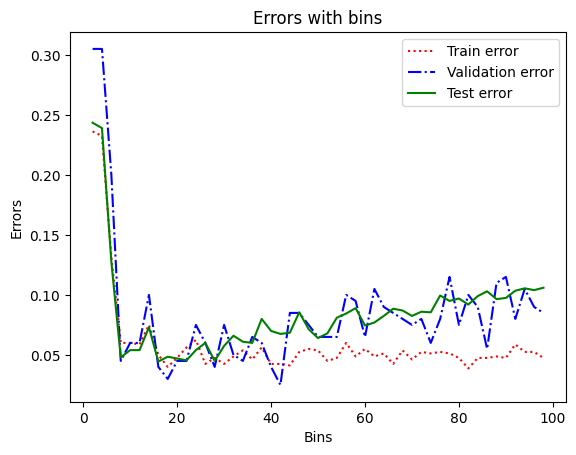

In [18]:
ejercicio_4_elipses()

### Conclusiones Ejercicio 4 Elipses

Para múltiples bins el las redes bayesianas logran representar el problema. Al haber más gaussianas el espacio de funciones que podemos generar es más amplia. 
El mejor resultado fue con 42 bines (muy curioso el número :O), sin embargo se puede notar viendo la gráfica que es una especie de outlier, pareciera que los valores se van deteriorando luego de 8-10 bins. De ahí en más hay un claro sobreajuste, el error de train decrece o se mantiene relativamente constante en 0.05 mientras el de entrenamiento y validación crecen. 

Best result was 86


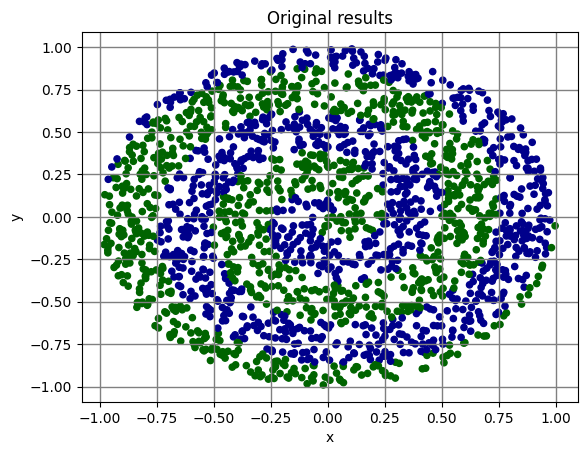

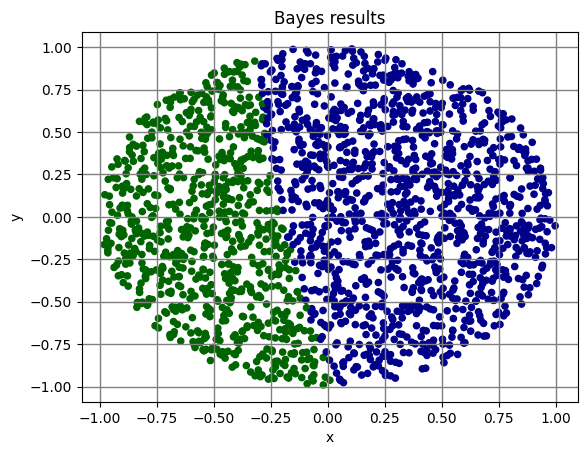

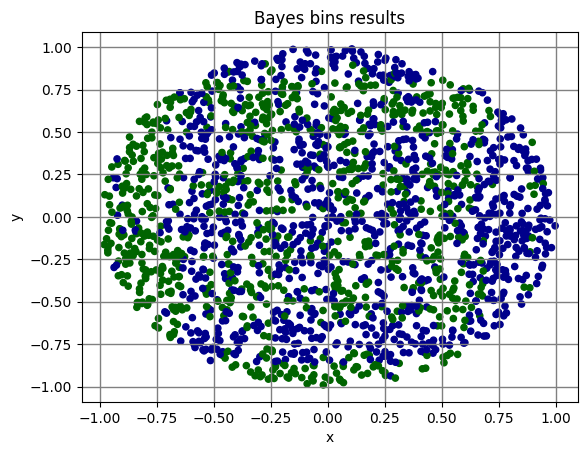

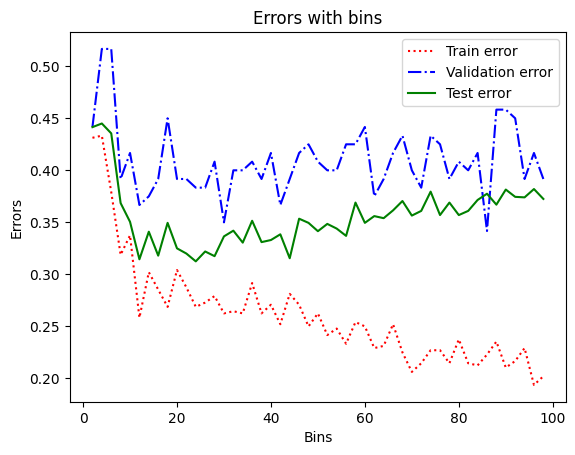

In [5]:
ejercicio_4_espirales()

### Conclusiones Ejercicio 4 Espirales

Si bien la representación mejoró muchísimo con múltiples bins, aún así el error es bastante grande. El mejor resultado es 86 bins, pero al igual que el caso anterior es un outlier.
También hay un claro sobreajuste a partir de 12-14 bins, pero el error es bastante grande incluso en ese momento. De esta forma podemos notar que las redes bayesianas no mejorarían con más bins, y este no es una buena forma de resolver este problema. 

## Ejercicio 5

In [9]:
def ejercicio_5():

    X, y = fetch_20newsgroups(subset="train",return_X_y=True, remove=["headers"])
    X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.25, random_state=1)
    X_test, y_test = fetch_20newsgroups(subset="test",return_X_y=True,remove=["headers"])

    table = []
    best_error_val = 1

    for size_dic in [1000, 1500, 2000, 2500, 3000, 3500, 4000]:
        for alfa in [0.0001, 0.001, 0.01, 0.1, 1]:    

            vec = CountVectorizer(stop_words='english',max_features=size_dic)
            Xvec_train = vec.fit_transform(X_train).toarray()
            Xvec_val = vec.transform(X_val).toarray()
            Xvec_test = vec.transform(X_test).toarray()

            clf = MultinomialNB(alpha=alfa)
            clf.fit(Xvec_train, y_train)

            results_test = clf.predict(Xvec_test)
            results_val = clf.predict(Xvec_val)
            results_train = clf.predict(Xvec_train)

            error_test = 1 - accuracy_score(y_test, results_test)
            error_train = 1 - accuracy_score(y_train, results_train)
            error_val = 1 - accuracy_score(y_val, results_val)

            table.append([alfa, size_dic, error_train, error_val, error_test])

            if error_val < best_error_val:
                best_error_val = error_val
                best_alfa = alfa
                best_size = size_dic
                best_error_test = deepcopy(results_test)
    
    print("Best combination alfa: " + str(best_alfa) + " size: " + str(best_size) + " has error: " + str(best_error_val))

    df_table = pd.DataFrame(table, columns = ["Alfa", "Size diccionario", "Error Train", "Error Val", "Error Test"])
    print(df_table)

    _, ax = mpl.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(y_test, best_error_test, display_labels=clf.classes_, ax=ax)
    mpl.show()


Best combination alfa: 0.1 size: 4000 has error: 0.23223753976670203
      Alfa  Size diccionario  Error Train  Error Val  Error Test
0   0.0001              1000     0.260577   0.349947    0.413436
1   0.0010              1000     0.261874   0.346766    0.410913
2   0.0100              1000     0.263642   0.346766    0.407329
3   0.1000              1000     0.267295   0.346059    0.408789
4   1.0000              1000     0.277431   0.353835    0.413436
5   0.0001              1500     0.210961   0.310004    0.378917
6   0.0010              1500     0.212610   0.303994    0.374535
7   0.0100              1500     0.215557   0.301873    0.369756
8   0.1000              1500     0.221567   0.300460    0.367233
9   1.0000              1500     0.234885   0.310710    0.371083
10  0.0001              2000     0.176547   0.293743    0.360595
11  0.0010              2000     0.178786   0.287734    0.353824
12  0.0100              2000     0.183736   0.285967    0.346389
13  0.1000           

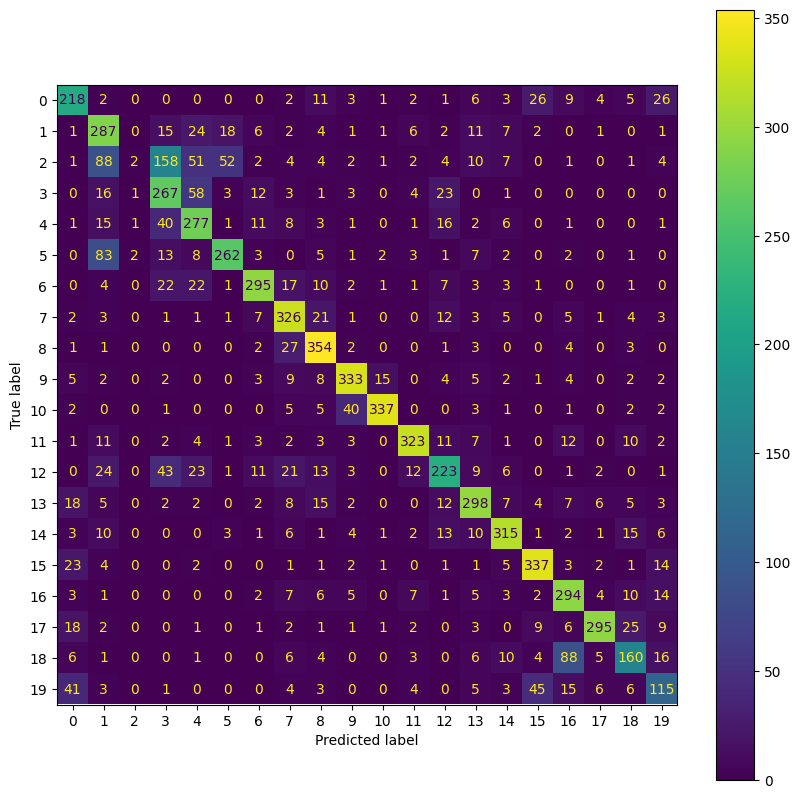

In [10]:
ejercicio_5()

### Conclusiones ejercicio 5

Como podemos observar en la tabla, en general, los valores de error en test van decreciendo a medida que aumenta el tamaño del diccionario. Si bien el mejor resultado para la validación fue 4000 y 0.1 de alfa. La diferencia no es tan grande para el alfa, para el tamaño se nota un poco más pero va convergiendo a medida que aumenta el tamaño.

El error en general es bastante grande, comparativamente. Probablemente porque el tamaño de valores por clase no es tan grande. 

Para la mayoría de las clases funciona bastante bien, la mayoría de los ejemplos funciona bastante bien, no es tanta diferencia. Aunque en particular la clase 2 funciona bastante pésimo. No sabría decir exactamente por qué. 
